In [2]:
pip install pmdarima

## Importing libraries

In [71]:
# Data lib
import pandas as pd
import numpy as np

# Viz lib
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# ML lib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest
import pmdarima as pm
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

## Loading data

In [72]:
# Loading the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_consumption_project/power_cons_data_clean.csv', parse_dates=['Date_time'])

In [73]:
# Checking the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Date_time              datetime64[ns]
 8   Year                   int64         
 9   Month                  int64         
 10  Week_num               int64         
 11  Month_day              int64         
 12  Week_day               int64         
 13  Year_day               int64         
 14  Hour                   int64         
 15  Season                 int64         
dtypes: datetime64[ns](1), float64(7), int64(8)
memory usage: 253.3 MB


## Exploratory

In [74]:
# Grouping the data on daily interval
data_daily = data.groupby(pd.Grouper(key='Date_time', freq='D')).agg({'Global_active_power':'sum', 
                                                                            'Sub_metering_1':'sum', 
                                                                            'Sub_metering_2':'sum', 
                                                                            'Sub_metering_3':'sum'}).reset_index()

In [75]:
data_daily.head()

,Date_time,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,0.0,546.0,4926.0
1,2006-12-17,3390.460,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,839.0,7602.0,6197.0
4,2006-12-20,2225.748,0.0,2648.0,14063.0


In [76]:
# Converting all zero values to the mean of Global_active_power
data_daily['Global_active_power'] = data_daily['Global_active_power'].replace(0, np.nan).fillna(data_daily['Global_active_power'].mean())

# Removing all outliers from Global_active_power
data_arm = data_daily[((data_daily['Global_active_power'] < 3000) & (data_daily['Global_active_power'] > 100))]

In [77]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

In [78]:
#Testing stationary
ts = data_daily[['Date_time', 'Global_active_power']]
ts.set_index('Date_time', inplace=True)
mte = data_daily['Global_active_power']

In [79]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [80]:
TestStationaryAdfuller(mte)

Test Statistic                -9.369743e+00
p-value                        7.432659e-16
#Lags Used                     7.000000e+00
Number of Observations Used    1.449000e+03
Critical Value (1%)           -3.434871e+00
Critical Value (5%)           -2.863537e+00
Critical Value (10%)          -2.567833e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [81]:
moving_avg = mte.rolling(12).mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
  y=mte, name='Global Active Power'
))

fig.add_trace(go.Scatter(
  y=moving_avg, name='Moving Average'
))

# Title settings
fig.update_layout(
    title={
        'text': 'Moving Average on Global Active Power',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# Legend settings
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))
fig.show()

In [82]:
mte.index = data_daily['Date_time']

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mte)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [84]:
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(
    y=mte, name='Original'
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=trend, name='Trend'
), row=2, col=1)

fig.add_trace(go.Scatter(
    y=seasonal, name='Seasonality'
), row=3, col=1)

fig.add_trace(go.Scatter(
    y=residual, name='Residuals'
), row=4, col=1)

# Title settings
fig.update_layout(
    title={
        'text': 'Decomposition of Trend/Seasonality/Residuality',
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        height=800)

# Legend settings
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

fig.show()

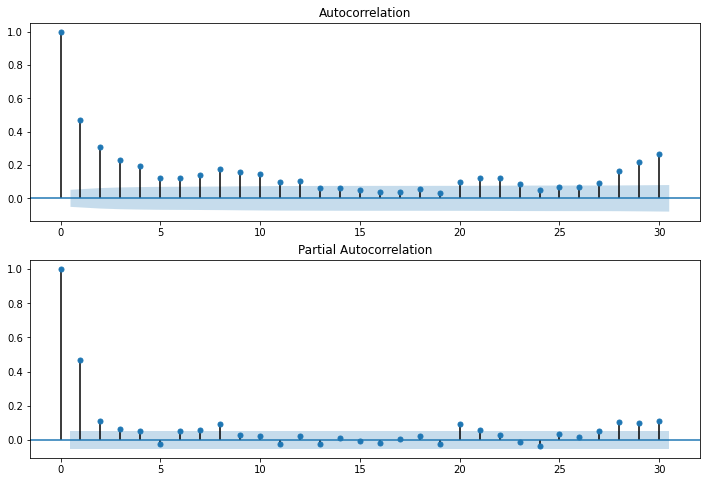

In [85]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte, lags=30, ax=ax2)

## Train and Test split

In [86]:
# Train - Test Split -> test data will have 90 days for validation
threshold_date = pd.to_datetime('2010-09-13')
mask = data_arm['Date_time'] < threshold_date

data_arm_train = data_arm[mask][['Date_time', 'Global_active_power',
                                 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
data_arm_train.set_index('Date_time', inplace=True)

data_arm_test = data_arm[~mask][['Date_time', 'Global_active_power',
                                 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
data_arm_test.set_index('Date_time', inplace=True)

exogenous_features = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [87]:
print(data_arm_train.describe())
print(data_arm_test.describe())

       Global_active_power  Sub_metering_1  Sub_metering_2  Sub_metering_3
count          1333.000000     1333.000000     1333.000000     1333.000000
mean           1524.463553     1544.985746     1795.207052     9019.888972
std             543.560695     1529.402991     2049.668807     3796.893841
min             131.732000        0.000000        0.000000        0.000000
25%            1161.016000      429.000000      413.000000     6503.000000
50%            1534.874000     1105.000000      659.000000     9086.000000
75%            1866.886000     2174.000000     2644.000000    11568.000000
max            2987.854000    11178.000000    12109.000000    23743.000000
       Global_active_power  Sub_metering_1  Sub_metering_2  Sub_metering_3
count            90.000000       90.000000       90.000000       90.000000
mean           1518.455948     1289.077778     1377.066667     8951.066667
std             446.538184     1273.685498     1759.176779     4402.392240
min             106.00600

In [88]:
# Plotting the train and test dataset
fig_split = make_subplots()
fig_split.add_trace(go.Scatter(
    x=data_arm_train.index,
    y=data_arm_train['Global_active_power'],
    name='Y_Train'
    ))

fig_split.add_trace(go.Scatter(
    x=data_arm_test.index,
    y=data_arm_test['Global_active_power'],
    name='Y_Test'
    ))

# Setting up the names
fig_split.update_yaxes(title_text="<b>Power</b> kilowatt [kW]")
fig_split.update_xaxes(title_text="<b>Dates")

# Setting up the layout
fig_split.update_layout(
    title={
    'text': "<b>Train and Test data split</b>",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    autosize=True, 
    legend=dict(
                orientation="h",
                yanchor="top",
                y=1.12,
                xanchor="center",
                x=0.5))
fig_split.show()

## Models building - SARIMAX

In [ ]:
# Building the model - SARIMAX
model_sarm = pm.auto_arima(data_arm_train['Global_active_power'], 
                            start_p=0, start_q=0,
                            max_p=14, max_q=3,
                            seasonal=True, m=12,     # Monthly seasonality
                            exogenous = data_arm_train[['Sub_metering_3', 'Sub_metering_2', 'Sub_metering_1']].values,
                            d=None, trace=True,
                            random_state=0,
                            error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=True,  # we don't want convergence warnings
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=19810.842, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=19807.284, Time=0.27 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=19590.139, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=19389.560, Time=2.72 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=19805.286, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=19385.924, Time=1.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=19389.596, Time=2.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=19390.725, Time=4.59 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=19294.069, Time=1.86 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=19307.814, Time=4.92 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=19303.330, Time=5.62 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=6.43 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=19588.215, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=19301.619, Time=1.48 sec
 ARIMA(1,1,

In [ ]:
# Showing the summary - Best model:  SARIMAX(1,1,3)(0,0,0)[12]
print(model_sarm.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1333
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -9637.777
Date:                Sun, 20 Jun 2021   AIC                          19285.555
Time:                        15:37:09   BIC                          19311.527
Sample:                             0   HQIC                         19295.288
                               - 1333                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0957      0.002     43.496      0.000       0.091       0.100
ar.L1          0.5386      0.076      7.086      0.000       0.390       0.688
ma.L1         -1.2366      0.086    -14.360      0.0

Params: 


*    start_p=1, start_q=1
*    test='adf'
*    max_p=3, max_q=3, m=12
*    start_P=0, seasonal=True
*    d=None, D=1, trace=True
*    error_action='ignore'  
*    suppress_warnings=True
*    stepwise=True


<b> Best model: SARIMAX(2,0,0)(2,1,0)[12]</b>

In [ ]:
# Model fit SARIMAX
model_sarm.fit(data_arm_train['Global_active_power'])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

## Models Building - ARIMA

In [117]:
# # Building the model - ARIMA
# MAPE - 24%
# model_arm = pm.auto_arima(data_arm_train.Global_active_power, 
#                           exogenous=data_arm_train[exogenous_features],
#                           seasonal=True, m=12,
#                           error_action='ignore', trace=True,
#                           supress_warnings=True,
#                           random_state=0)

# MAPE - 39%
# model_arm = pm.auto_arima(data_arm_train.Global_active_power,
#                           exogenous=data_arm_train[exogenous_features],
#                           start_p=1, start_q=1,
#                           test='adf',
#                           max_p=3, max_q=3, m=12,
#                           start_P=0, seasonal=True,
#                           d=None, D=1, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# RMSE - 354.5
# MAPE - 24.99%
# model_arm = pm.auto_arima(data_arm_train.Global_active_power,
#                           exogenous=data_arm_train[exogenous_features],
#                           m=7, seasonal=True,
#                           stationary=True,
#                           d=0, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True,
#                           random_state=0)

# MAPE - 24.99%
# model_arm = pm.auto_arima(data_arm_train.Global_active_power,
#                           exogenous=data_arm_train[exogenous_features],
#                           m=4, seasonal=True,
#                           stationary=True,
#                           d=0, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True,
#                           random_state=0)

# Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
# MAPE - 24.99%
model_arm = pm.auto_arima(data_arm_train.Global_active_power,
                          exogenous=data_arm_train[exogenous_features],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          seasonality=False,
                          stationary=True,
                          start_P=0,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True,
                          random_state=0)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18592.322, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18959.110, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18745.973, Time=0.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18901.575, Time=1.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19351.560, Time=1.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18555.502, Time=2.83 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18658.283, Time=2.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=18671.857, Time=3.73 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18666.801, Time=3.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=18686.899, Time=3.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=18648.769, Time=2.84 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18670.522, Time=3.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18608.404, Time=2.39 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 31.114 seconds


In [118]:
# Showing the summary
print(model_arm.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1333
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -9269.751
Date:                Tue, 22 Jun 2021   AIC                          18555.502
Time:                        22:31:05   BIC                          18597.063
Sample:                             0   HQIC                         18571.076
                               - 1333                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         38.4302     17.245      2.228      0.026       4.631      72.230
Sub_metering_1     0.0927      0.004     21.394      0.000       0.084       0.101
Sub_metering_2     0.0678      0.004

In [119]:
# Model fit ARIMA
model_arm.fit(data_arm_train['Global_active_power'], exogenous=data_arm_train[exogenous_features])

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [120]:
forecast = model_arm.predict(n_periods = len(data_arm_test), exogenous=data_arm_test[exogenous_features])
data_arm_test['Forecast_Multivar'] = forecast

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [112]:
# Plotting the train and test dataset
fig_pred = make_subplots()
fig_pred.add_trace(go.Scatter(
    x=data_arm_train.index,
    y=data_arm_train['Global_active_power'],
    name='Y_Train'
    ))

fig_pred.add_trace(go.Scatter(
    x=data_arm_test.index,
    y=data_arm_test['Global_active_power'],
    name='Y_Test'
    ))

fig_pred.add_trace(go.Scatter(
    x=data_arm_test.index,
    y=data_arm_test['Forecast_Multivar'],
    name='Y_Pred'
    ))

# Setting up the names
fig_pred.update_yaxes(title_text="<b>Power</b> kilowatt [kW]")
fig_pred.update_xaxes(title_text="<b>Dates")

# Setting up the layout
fig_pred.update_layout(
    title={
    'text': "<b>Train and Test data split</b>",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    autosize=True, 
    legend=dict(
                orientation="h",
                yanchor="top",
                y=1.12,
                xanchor="center",
                x=0.5))
fig_pred.show()

In [121]:
def mean_absolute_percentage_error(y_true, y_pred):
    'Function to define a formula for calculating MAPE' 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Evaluation of Arima
print('ARIMA - MAE result: ',metrics.mean_absolute_error(data_arm_test['Global_active_power'], data_arm_test['Forecast_Multivar']))
print('ARIMA - MSE result: ',metrics.mean_squared_error(data_arm_test['Global_active_power'], data_arm_test['Forecast_Multivar']))
print('ARIMA - RMSE result',np.sqrt(metrics.mean_squared_error(data_arm_test['Global_active_power'], data_arm_test['Forecast_Multivar'])))
print('ARIMA - MAPE :',mean_absolute_percentage_error(data_arm_test['Global_active_power'], data_arm_test['Forecast_Multivar']),  '%')

ARIMA - MAE result:  251.81424775765905
ARIMA - MSE result:  125703.91667715806
ARIMA - RMSE result 354.5474815552327
ARIMA - MAPE : 24.99 %


In [122]:
# Saving the Multivariate model
import pickle

path = '/content/drive/MyDrive/Colab Notebooks/power_consumption_project/'

with open(path +'ARIMA_model_pickle.sav', 'wb') as f:
     pickle.dump(forecast, f)

## SARIMAX Forecasting and Evaluation

In [ ]:
# Forecasting SARIMAX
forecast_sarm = model_sarm.predict(n_periods=len(data_arm_test))
forecast_sarm = pd.DataFrame(forecast_sarm, index=data_arm_test.index, columns=['Forecast_GAP'])

# Making DataFrame of Test and Forecast data for plotting purpose
forecast_sarm.set_index(data_arm_test['Date_time'], inplace=True)
forecast_sarm['Test_GAP'] = data_arm_test['Global_active_power'].values

In [ ]:
# Ploting the SARIMAX model
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast_sarm.index, y=forecast_sarm['Test_GAP'], name='Test data'
))

fig.add_trace(go.Scatter(
    x=forecast_sarm.index, y=forecast_sarm['Forecast_GAP'], name='Forecast data'
))

# Time range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True),
        type="date"
    )
)

# Title settings
fig.update_layout(
    title={
        'text': 'Test data vs Forecast <b>SARIMAX Model</b> - 90 days',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# Legend settings
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

fig.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    'Function to define a formula for calculating MAPE' 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Evaluation of Arima
print('SAMIRAX - MAE result: ',metrics.mean_absolute_error(forecast_sarm['Test_GAP'], forecast_sarm['Forecast_GAP']))
print('SAMIRAX - MSE result: ',metrics.mean_squared_error(forecast_sarm['Test_GAP'], forecast_sarm['Forecast_GAP']))
print('SAMIRAX - RMSE result',np.sqrt(metrics.mean_squared_error(forecast_sarm['Test_GAP'], forecast_sarm['Forecast_GAP'])))
print('SAMIRAX - MAPE :',mean_absolute_percentage_error(forecast_sarm['Test_GAP'], forecast_sarm['Forecast_GAP']),  '%')

SAMIRAX - MAE result:  359.59375009378124
SAMIRAX - MSE result:  218206.88310488214
SAMIRAX - RMSE result 467.1261961235766
SAMIRAX - MAPE : 39.15 %


## ARIMA Model Forecasting and Evaluation

In [ ]:
# Forecasting ARIMA
forecast_arm = model_arm.predict(n_periods=len(data_arm_test))
forecast_arm = pd.DataFrame(forecast_arm, index = data_arm_test.index, columns=['Forecast_GAP'])

# Making DataFrame of Test and Forecast data for plotting purpose
forecast_arm.set_index(data_arm_test['Date_time'], inplace=True)
forecast_arm['Test_GAP'] = data_arm_test['Global_active_power'].values

In [ ]:
# Ploting the ARIMA model
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast_arm.index, y=forecast_arm['Test_GAP'], name='Test data'
))

fig.add_trace(go.Scatter(
    x=forecast_arm.index, y=forecast_arm['Forecast_GAP'], name='Forecast data'
))

# Time range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True),
        type="date"
    )
)

# Title settings
fig.update_layout(
    title={
        'text': 'Test data vs Forecast <b>ARIMA Model</b> - 90 days',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# Legend settings
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

fig.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    'Function to define a formula for calculating MAPE' 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Evaluation of Arima
print('ARIMA - MAE result: ',metrics.mean_absolute_error(forecast_arm['Test_GAP'], forecast_arm['Forecast_GAP']))
print('ARIMA - MSE result: ',metrics.mean_squared_error(forecast_arm['Test_GAP'], forecast_arm['Forecast_GAP']))
print('ARIMA - RMSE result',np.sqrt(metrics.mean_squared_error(forecast_arm['Test_GAP'], forecast_arm['Forecast_GAP'])))
print('ARIMA - MAPE :',mean_absolute_percentage_error(forecast_arm['Test_GAP'], forecast_arm['Forecast_GAP']),  '%')

ARIMA - MAE result:  367.0598135228867
ARIMA - MSE result:  223866.5472753341
ARIMA - RMSE result 473.14537647041857
ARIMA - MAPE : 39.32 %


Default params:
---
SAMIRAX - MAE result:  444.9651611173349

SAMIRAX - MSE result:  335281.1684982349

SAMIRAX - RMSE result 579.0346867833005

SAMIRAX - MAPE : 50.57 %

---
ARIMA - MAE result:  367.0598135228867

ARIMA - MSE result:  223866.5472753341

ARIMA - RMSE result 473.14537647041857

ARIMA - MAPE : 39.32 %

### PARAMS

In [ ]:
# # SARIMAX PARAMS - Default: - Best model:  SARIMAX(2,0,0)(2,1,0)[12]
# model_sarm = pm.auto_arima(data_arm_train['Global_active_power'], 
#                             start_p=1, start_q=1,
#                             test='adf',
#                             max_p=3, max_q=3, m=12,
#                             start_P=0, seasonal=True,
#                             d=None, D=1, trace=True,
#                             error_action='ignore',  
#                             suppress_warnings=True, 
#                             stepwise=True)

In [ ]:
# # SARMIAX PARAMS - Updated: - (2,1,1)(0,0,0,7)
# model_sarm = pm.auto_arima(data_arm_train['Global_active_power'], 
#                             start_p=0, start_q=0,
#                             max_p=14, max_q=3,
#                             seasonal=True, m=7,     # Weekly seasonality
#                             exogenous = data_arm_train[['Sub_metering_1', 
#                                                         'Sub_metering_2', 
#                                                         'Sub_metering_3']].values,
#                             d=None, trace=True,
#                             random_state=0,
#                             out_of_sample_size=28,
#                             error_action='ignore',   # we don't want to know if an order does not work
#                             suppress_warnings=True,  # we don't want convergence warnings
#                             stepwise=True)